In [2]:
import sys
sys.path.append("../../../")

## 数据

In [3]:
import matplotlib.pyplot as plt
from pylib.utils.functions_for_classification import mixed_2d_2cls, plot_scatter

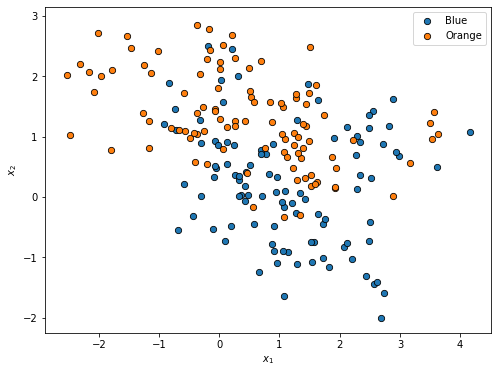

In [4]:
X_train, X_test, y_train, y_test = mixed_2d_2cls()
plt.figure(figsize=(8, 6))
plot_scatter(X_train, y_train)
plt.show()

## 立方样条

In [4]:
from pylib.utils.functions_for_classification import plot_decision_boundary
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

In [5]:
class CubicSplineFeatures(BaseEstimator, TransformerMixin):
    """
    立方样条特征
    
    参数
    ----
    knots: 结点值列表
    dofs: 自由度。在立方样条中，这个值应该大于4
    """
    def __init__(self, knots=None, dofs=None):
        self.knots = [knots] if knots is not None else None
        self.dofs = dofs
        self.order = 4
        
    def fit(self, X, y=None):
        p = X.shape[1]
        if self.dofs is not None:
            if self.dofs <= self.order:
                  raise Exception("Please input a degree of freedom > 4")
            quantiles = np.linspace(0, 1, self.dofs - self.order)
            self.knots = []
            for i in range(p):
                self.knots.append(np.unique(np.quantile(X[:, i], quantiles)).tolist())
        return self

    def transform(self, X):
        H = []
        knots = np.array(self.knots).ravel()
        for i in range(X.shape[1]):
            for j in range(self.order):
                H.append(X[:, i]**j)
            for k in knots:
                H.append(np.where((X[:, i] - k)**3 > 0, (X[:, i] - k)**3, 0))
        return np.array(H).T

In [6]:
cs_pipeline = Pipeline([("cubic_spline", CubicSplineFeatures(dofs=8)),
                         ("scaler", StandardScaler()),
                         ("linreg", LogisticRegression())])
cs_pipeline.fit(X_train, y_train)

E:\a-soft\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('cubic_spline',
                 CubicSplineFeatures(dofs=8,
                                     knots=[[-2.520819677, 0.20527879300000001,
                                             1.3235876703333331, 4.170746208],
                                            [-1.999853402, 0.3595632366666667,
                                             1.1924048963333331,
                                             2.855804967]])),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linreg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', 

In [7]:
train_err = 1 - cs_pipeline.score(X_train, y_train)
print("训练样本误差：{:.3f}".format(train_err))

训练样本误差：0.250


In [8]:
test_err = 1 - cs_pipeline.score(X_test, y_test)
print("测试样本误差：{:.3f}".format(test_err))

测试样本误差：0.250


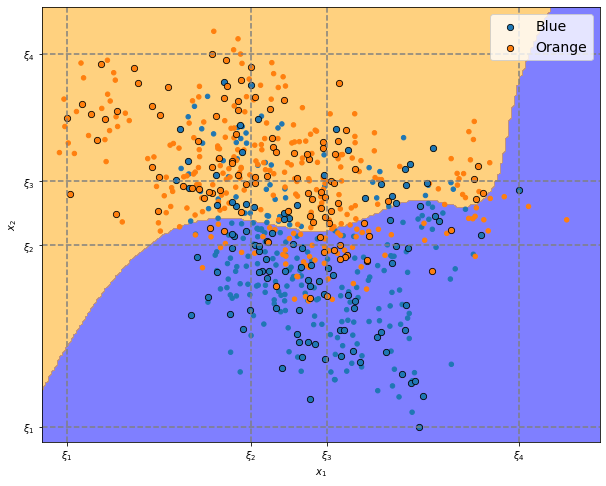

In [9]:
# 画出决策边界
knots = cs_pipeline.named_steps["cubic_spline"].knots

plt.figure(figsize=(10, 8))
plot_decision_boundary(X_train, y_train, X_test, y_test, cs_pipeline)
ylim_min = plt.ylim()[0]
ylim_max = plt.ylim()[1]
xlim_min = plt.xlim()[0]
xlim_max = plt.xlim()[1]
x_labels = []
y_labels = []
for i, xi in enumerate(knots[0]):
    plt.vlines(xi, ylim_min, ylim_max, linestyles='--', colors='gray')
    x_labels.append(r'$\xi_{}$'.format(i + 1))
for i, xi in enumerate(knots[1]):
    plt.hlines(xi, xlim_min, xlim_max, linestyles='--', colors='gray')
    y_labels.append(r'$\xi_{}$'.format(i + 1))
plt.legend(fontsize=14)
plt.xticks(knots[0], x_labels)
plt.yticks(knots[1], y_labels)
plt.show()

### 寻找最优参数

In [10]:
from sklearn.model_selection import GridSearchCV

In [11]:
cs_pipeline = Pipeline([("cubic_spline", CubicSplineFeatures()),
                         ("scaler", StandardScaler()),
                         ("linreg", LogisticRegression())])
param_grid = {"cubic_spline__dofs": np.arange(5, 31, 1)}
cs_cv = GridSearchCV(
    cs_pipeline,
    param_grid,
    cv=10,
    n_jobs=-1
)
cs_cv.fit(X_train, y_train)

E:\a-soft\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('cubic_spline',
                                        CubicSplineFeatures(dofs=None,
                                                            knots=None)),
                                       ('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('linreg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                  

In [12]:
print("最优自由度：{}".format(cs_cv.best_params_['cubic_spline__dofs']))

最优自由度：27


### 使用最优模型

In [13]:
cs_best = cs_cv.best_estimator_

In [14]:
train_err = 1 - cs_best.score(X_train, y_train)
print("训练样本误差：{:.3f}".format(train_err))

训练样本误差：0.215


In [15]:
test_err = 1 - cs_best.score(X_test, y_test)
print("测试样本误差：{:.3f}".format(test_err))

测试样本误差：0.224


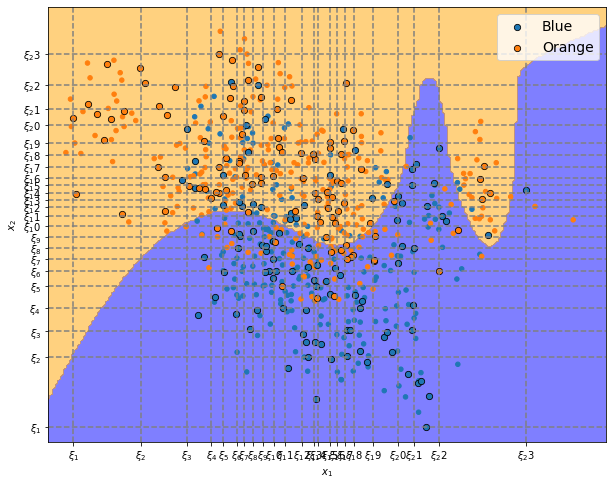

In [16]:
# 画出决策边界
knots = cs_best.named_steps["cubic_spline"].knots
plt.figure(figsize=(10, 8))
plot_decision_boundary(X_train, y_train, X_test, y_test, cs_best)
ylim_min = plt.ylim()[0]
ylim_max = plt.ylim()[1]
xlim_min = plt.xlim()[0]
xlim_max = plt.xlim()[1]
x_labels = []
y_labels = []
for i, xi in enumerate(knots[0]):
    plt.vlines(xi, ylim_min, ylim_max, linestyles='--', colors='gray')
    x_labels.append(r'$\xi_{}$'.format(i + 1))
for i, xi in enumerate(knots[1]):
    plt.hlines(xi, xlim_min, xlim_max, linestyles='--', colors='gray')
    y_labels.append(r'$\xi_{}$'.format(i + 1))
plt.legend(fontsize=14)
plt.xticks(knots[0], x_labels)
plt.yticks(knots[1], y_labels)
plt.show()

### 截断幂数基

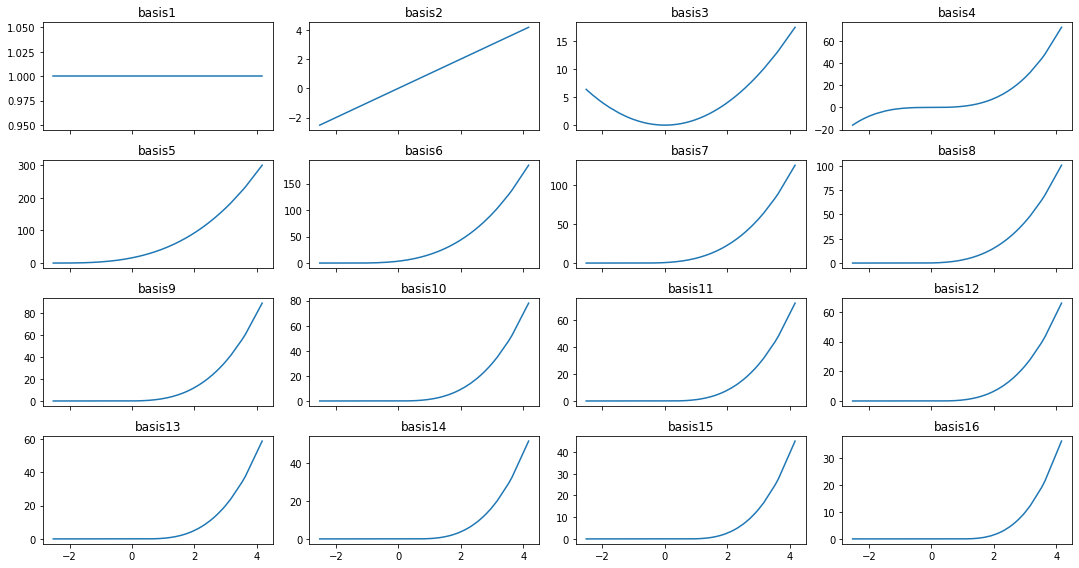

In [21]:
# 以第一个特征为例
H = cs_best.named_steps["cubic_spline"].transform(X_train[:, 0].reshape(-1, 1))
X_sort = np.sort(X_train[:, 0].ravel())
H_sort = H[np.argsort(X_train[:, 0].ravel())]

fig, axes = plt.subplots(4, 4, sharex=True, figsize=(15, 8))
axes = axes.flatten()
for i in range(16):
    axes[i].plot(X_sort, H_sort[:, i])
    axes[i].set_title("basis{}".format(i+1))
plt.tight_layout()
plt.show()